# Localisation Indoor (IMU + WiFi) - Rapport technique

### 1. Contexte et problematique
Ce travail étudie la localisation indoor en 2D a partir de WiFi (RSSI) et capteurs inertiels.
L'objectif est d'évaluer la faisabilité d'approches data-driven, leurs limites et la robustesse
inter-device (ESP32 vs smartphone) dans un environnement réaliste.

### 2. Objectifs
- Construire un pipeline complet : import, nettoyage, densification des labels, feature engineering, entrainement, évaluation.
- Comparer des modèles pointwise (kNN, RandomForest, XGBoost) et séquentiels (LSTM, GRU).
- Mesurer la généralisation cross-device et analyser les erreurs par session.

### 3. Donnees et contraintes
- Trajectoires indoor multiples, devices ESP32 et Samsung, contextes de mouvement variés.
- Labels ponctuels densifiés par interpolation lineaire entre ancres.
- Forte sparsity des mesures WiFi (NaN) et bruit capteurs IMU.

### 4. Methodologie (resume)
- Pretraitement : filtrage colonnes, timestamp, imputation des valeurs manquantes.
- Feature engineering : top-K AP, rolling IMU, derivées et statistiques simples.
- Modèles tabulaires et séquentiels, avec metriques 2D adaptées.

### 5. Protocole experimental
- Splits par trajectoire/device pour éviter la fuite temporelle.
- Metriques basées sur l'erreur radiale + percentiles (p68/p90/p95) + CDF.
- Analyse par session (device/motion) pour quantifier la robustesse.

### 6. Reproductibilite
- Dependances listées dans environment.yml.
- Les resultats doivent rester stables à epsilon près (variations mineures entre runs).

### 7. Limites et menaces a la validite
- Densification linéaire : hypothèse forte si la dynamique réelle est non linéaire.
- Domain shift inter-device (offsets RSSI/IMU).
- Synchronisation temporelle et bruit capteurs.

### 8. Organisation du notebook
1) Import & EDA
2) Pretraitement
3) Feature engineering
4) Modèles tabulaires & séquentiels
5) Analyse par trajectoire et synthèse


## Étape 1 — Importation et exploration des données

Cette section rassemble le nettoyage des runs précédentes, l'import des fichiers CSV et la consolidation en un DataFrame unifié.

In [ ]:
from pathlib import Path
import sys, logging
import pandas as pd
import matplotlib.pyplot as plt
import json
import numpy as np

sys.path.append(str(Path.cwd() / "src"))

from src.config import Config, set_global_seed
from src import paths, artifacts, io_data, preprocessing, splitting, evaluation, plotting, feature_engineering, metrics

logging.basicConfig(level=logging.INFO)
cfg = Config()
run_id = "v1"
K = 20  # shared K for WiFi top-K, PCA components, top-K corr
force_recompute = True
cfg.top_k = K
cfg.wifi_topk = K
cfg.seq_pca_n_components = K
cfg.seq_pca_topk_corr = K
cfg.seq_topk_corr_k = K
cfg.seq_target_mode = "abs"
cfg.run_id = run_id
cfg.force_recompute = force_recompute
paths.ensure_dirs()
set_global_seed(cfg.random_seed)


In [2]:
df_base_path = artifacts.artifact_path("data", "df_base", run_id, "csv")
if artifacts.exists(df_base_path) and not force_recompute:
    df_base = artifacts.load_df(df_base_path)
else:
    dfs = io_data.load_or_download_dataset(cfg.zip_url, cfg.cache_dir_raw, force=force_recompute)
    df_base = preprocessing.make_base_dataframe(dfs, max_nan_ratio=cfg.max_nan_ratio)
    artifacts.save_df(df_base, df_base_path)

print(df_base.shape)
df_base.head()


(10156, 25)


,AccelX,AccelY,AccelZ,ClickShare-1862482789_9c:2f:9d:5f:1e:ad,GyroX,GyroY,GyroZ,MagnetoX,MagnetoY,MagnetoZ,...,eduroam_c8:b5:ad:f3:6b:60,eduroam_c8:b5:ad:f3:6b:70,eduroam_c8:b5:ad:f3:73:20,eduroam_cc:88:c7:03:a4:a0,eduroam_cc:d0:83:a0:e0:a0,eduroam_f0:5c:19:c3:5d:a0,label_X,label_Y,motion,t_ms
0,0.024327,-0.023169,-0.033812,NaN,5.751394,3.090716,-4.843351,18.4125,-41.540627,-58.95,...,-80.0,NaN,-85.0,NaN,NaN,-82.0,0.0,0.00,combined,62660160
1,0.019668,-0.019916,-0.030376,NaN,6.129481,3.317296,-4.349599,18.4125,-41.540627,-58.95,...,-80.0,NaN,-85.0,NaN,NaN,-82.0,0.0,0.12,combined,62660340
2,0.016780,-0.017610,-0.027619,NaN,6.176035,3.099685,-3.871164,18.4125,-41.540627,-58.95,...,-80.0,NaN,-85.0,NaN,NaN,-82.0,0.0,0.24,combined,62660500
3,0.015541,-0.016331,-0.025756,NaN,5.827854,2.485486,-3.365333,18.4125,-41.540627,-58.95,...,-80.0,NaN,-85.0,NaN,NaN,-82.0,0.0,0.36,combined,62660680
4,0.015629,-0.015893,-0.024806,NaN,5.045194,1.555934,-2.817180,18.4125,-41.540627,-58.95,...,-80.0,NaN,-85.0,NaN,NaN,-82.0,0.0,0.48,combined,62660850


### Jeu de données — détails d'acquisition  
- Sources : acquisitions multi‑fichiers (ESP32 / Samsung, différents parcours : horizontal, vertical, carré, combiné).  
- Capteurs : Accéléromètre, Gyroscope, Magnétomètre, mesures Wi‑Fi (RSSI par point d'accès).  
- Labels : positions ponctuelles (X,Y) présentes périodiquement → interpolation spatiale pour densifier (label_X,label_Y).  
- Remarques : présence importante de NaN sur certaines colonnes Wi‑Fi, nécessité d'une sélection robuste d'APs (top‑k).

## Analyse exploratoire (EDA) — buts et points de contrôle

Buts :
- Vérifier la couverture spatiale des trajectoires et repérer sessions dominantes qui pourraient biaiser l'évaluation.
- Evaluer la présence et la variance des AP Wi‑Fi pour sélectionner un sous‑ensemble informatif (top‑K).
- Rechercher corrélations éventuelles IMU ↔ positions (diagnostic de features utiles).

Points de contrôle à réaliser après exécution :
- Visualiser anchors vs labels densifiés pour 5 trajectoires aléatoires.
- Examiner la distribution de t_ms (dt médian, outliers) par session.
- Construire un tableau AP (presence, variance) et valider le seuil de présence minimal utilisé en FE.

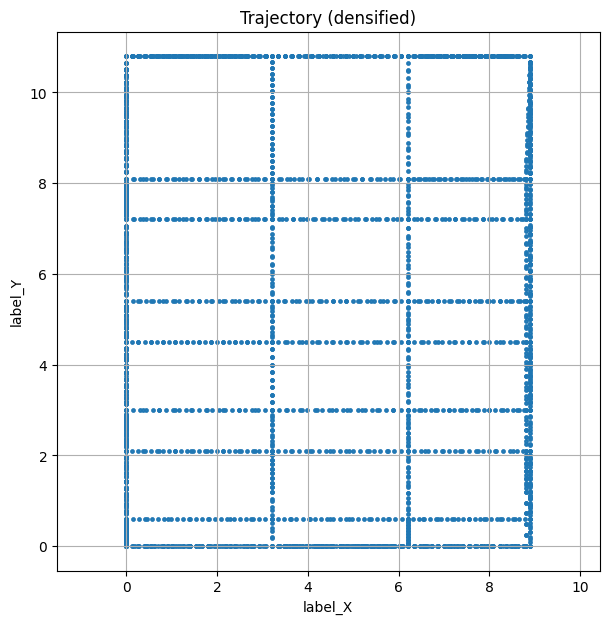

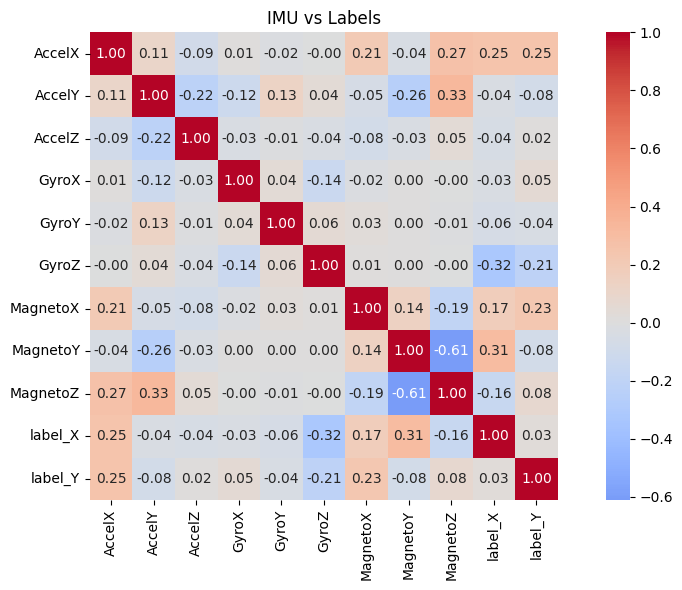

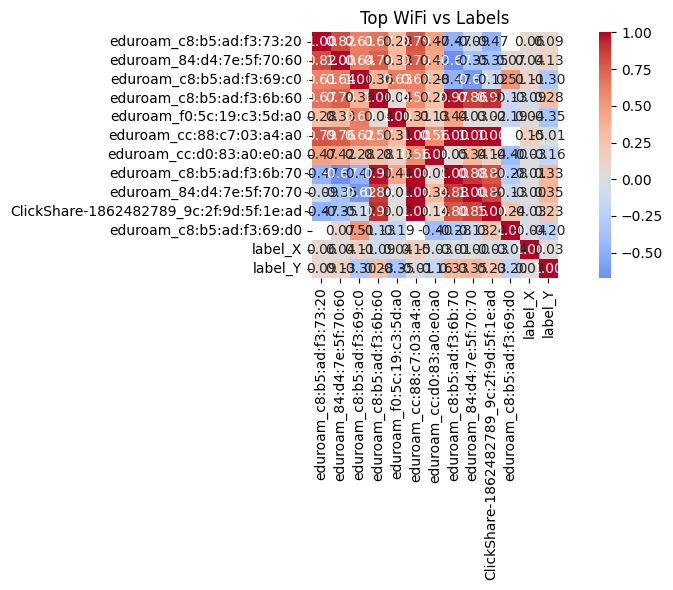

In [3]:
plotting.plot_trajectory(
    df_base,
    title="Trajectory (densified)",
    save_path=paths.out_figures_dir() / f"traj__{run_id}.png",
)

imu_cols = [c for c in cfg.imu_cols if c in df_base.columns]
if imu_cols:
    plotting.plot_corr_heatmap(
        df_base, imu_cols + ["label_X", "label_Y"],
        title="IMU vs Labels",
        save_path=paths.out_figures_dir() / f"corr_imu__{run_id}.png",
    )

wifi_cols = feature_engineering.get_wifi_columns(df_base, cfg.wifi_prefixes)
if wifi_cols:
    wifi_stats = []
    for col in wifi_cols:
        presence_ratio = df_base[col].notna().mean()
        variance = df_base[col].var(skipna=True)
        wifi_stats.append((col, presence_ratio, variance))
    wifi_stats_df = pd.DataFrame(wifi_stats, columns=["AP", "presence_ratio", "variance"]).sort_values("variance", ascending=False)
    top_wifi = wifi_stats_df.head(cfg.wifi_topk)["AP"].tolist()
    if top_wifi:
        plotting.plot_corr_heatmap(
            df_base, top_wifi + ["label_X", "label_Y"],
            title="Top WiFi vs Labels",
            save_path=paths.out_figures_dir() / f"corr_wifi__{run_id}.png",
        )


## Étape 2 — Prétraitement

Étapes réalisées (implémentées dans le code) :
- Suppression des colonnes très partiellement renseignées (>56% NaN).
- Suppression des lignes sans labels (label_X, label_Y).
- Conversion Timestamp → t_ms et imputation robuste (médiane pour capteurs; RSSI traité plus tard).
- Remplacement des valeurs manquantes pour Magneto* par la médiane par colonne.

Raisonnement et risques :
- Densification linéaire des labels est simple et permet d'obtenir des cibles pour l'entraînement, mais peut introduire un biais sur trajectoires courbes → vérifier visuellement.
- Imputation par médiane stabilise les features IMU mais atténue la variabilité ; conserver diagnostics (variance avant/après).

In [4]:
null_ratio = df_base.isna().mean().sort_values(ascending=False)
null_ratio.head(15)

df_base = splitting.add_session_id(df_base)
splits_path = artifacts.artifact_path("splits", "train_test_idx", run_id, "npz")
if artifacts.exists(splits_path) and not force_recompute:
    split_data = artifacts.load_npz(splits_path)
    train_idx = split_data["train_idx"]
    test_idx = split_data["test_idx"]
else:
    df_train, df_test = splitting.group_split(df_base, "session_id", cfg.test_size, cfg.random_seed)
    train_idx = df_train.index.to_numpy()
    test_idx = df_test.index.to_numpy()
    artifacts.save_npz(splits_path, train_idx=train_idx, test_idx=test_idx)

df_train = df_base.loc[train_idx].reset_index(drop=True)
df_test = df_base.loc[test_idx].reset_index(drop=True)


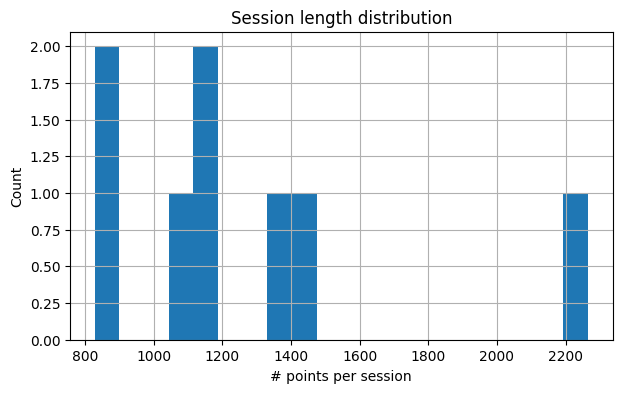

In [5]:
# Session length distribution
session_sizes = df_base.groupby("session_id").size().sort_values(ascending=False)
session_sizes.describe()

plt.figure(figsize=(7, 4))
session_sizes.hist(bins=20)
plt.title("Session length distribution")
plt.xlabel("# points per session")
plt.ylabel("Count")
plt.savefig(paths.out_figures_dir() / f"session_lengths__{run_id}.png", dpi=150, bbox_inches="tight")
plt.show()


## Étape 3 — Feature engineering

Le feature engineering a pour objectif de transformer les signaux bruts (WiFi et capteurs inertiels) en des représentations exploitables par les modèles d’apprentissage, tout en limitant le bruit et les risques de fuite de données.

Les transformations appliquées visent à améliorer la stabilité des modèles et leur capacité de généralisation, sans introduire de contraintes spatiales explicites.

---

### Signaux WiFi

Les traitements appliqués incluent :
- la sélection d’un sous-ensemble de points d’accès (top-k) afin de réduire la dimension et la sparsité,
- l’encodage des niveaux RSSI et de la présence des points d’accès,
- la suppression des signaux peu fréquents,
- la normalisation des variables numériques.

Ces traitements visent à conserver les signatures spatiales dominantes du WiFi tout en réduisant la variabilité instantanée du signal.

---

### Capteurs inertiels

Les signaux inertiels sont utilisés sous forme brute, complétés par :
- des dérivées temporelles simples,
- des statistiques glissantes (moyenne et écart-type).

Ces transformations apportent une information dynamique locale sur le mouvement, sans recourir à une intégration explicite (vitesse ou position), afin de limiter l’accumulation d’erreurs.

---

### Variables contextuelles

Les variables contextuelles, telles que le type de mouvement (`motion`), sont encodées par one-hot encoding.  
Le champ `device` est contrôlé ou exclu lors des tests cross-device afin d’éviter toute information non disponible en situation réelle.


In [6]:
bundle = evaluation.prepare_tabular_xy(df_train, df_test, cfg=cfg, run_id=run_id, force_recompute=force_recompute)
print("n_features:", len(bundle["feature_cols"]))
print("n_wifi:", len(bundle["wifi_cols"]))


n_features: 65
n_wifi: 11


In [7]:
# Essential features from top-K correlation (grouped)
topk_path = Path(paths.out_fe_dir()) / f"seq_topk_corr__{run_id}_topk{K}.json"
if topk_path.exists():
    topk = json.loads(topk_path.read_text(encoding="utf-8"))
    feats = topk.get("topk_corr_features", [])
    imu = [c for c in feats if c in cfg.imu_cols]
    roll = [c for c in feats if "_roll_" in c]
    deriv = [c for c in feats if c.endswith("_diff") or c.endswith("_dt")]
    wifi = [c for c in feats if c not in set(imu + roll + deriv)]
    summary = pd.DataFrame(
        {"group": ["imu", "roll", "deriv", "wifi"], "count": [len(imu), len(roll), len(deriv), len(wifi)]}
    )
    summary
    pd.DataFrame({"imu": pd.Series(imu), "roll": pd.Series(roll), "deriv": pd.Series(deriv), "wifi": pd.Series(wifi)}).head(20)
else:
    print("Top-K corr feature file not found:", topk_path)


Top-K corr feature file not found: C:\Users\flavi\GitHub\Indoor Localization\outputs\fe\seq_topk_corr__v1_topk20.json


### Résultats attendus du feature engineering

Les transformations appliquées ne visent pas à résoudre à elles seules le problème de localisation indoor, mais à :

- Améliorer la stabilité des prédictions pointwise.
- Réduire la variance des erreurs sur les sessions courantes.
- Faciliter l’apprentissage des modèles séquentiels en fournissant un contexte temporel local plus informatif.
- Mettre en évidence les limites structurelles du signal disponible, notamment en situation cross-device.

Les résultats montrent que le feature engineering permet d’extraire des informations pertinentes pour la localisation, tout en confirmant que l’absence de contraintes spatiales explicites (carte, topologie) constitue une limite fondamentale du système.

## Étape 4 — Modèles tabulaires

Approche : entraîner des modèles pointwise sur les features agrégées (rolling IMU, dérivées, top‑K Wi‑Fi) avec un préprocesseur (scaler + OHE). Les cibles sont label_X et label_Y (régression multivariée ou modèles séparés pour X et Y).

Modèles testés : LinearRegression (baseline), kNN (fingerprinting), RandomForest, XGBoost.

Attentes et diagnostics :
- Attente : RF / XGBoost surpassent la régression linéaire ; kNN performant localement mais sensible au bruit RSSI.
- En cas de résultats inattendus : rechercher fuite d'information, vérifier alignement colonnes train/test, inspecter importances et résidus par session.

c:\Users\flavi\GitHub\Indoor Localization\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\flavi\GitHub\Indoor Localization\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\flavi\GitHub\Indoor Localization\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(msg, UserWarning)
c:\Users\flavi\GitHub\Indoor Localization\.venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:261: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories wil

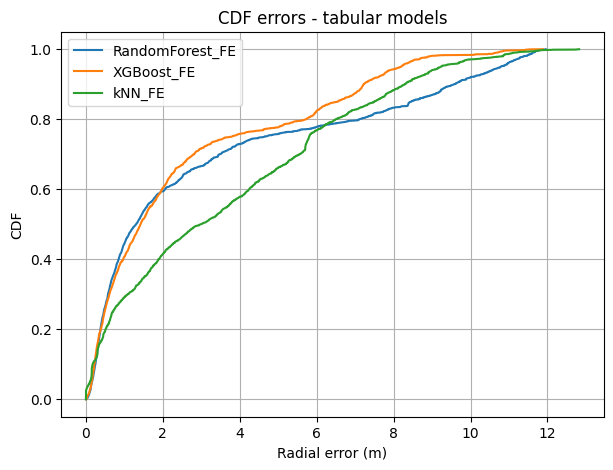

In [8]:
results_df, preds_by_model = evaluation.eval_tabular_models(bundle, cfg=cfg)
artifacts.save_df(results_df, artifacts.artifact_path("metrics", "results_tabular", run_id, "csv"))
results_df

plotting.plot_error_cdf(
    results_df,
    title="CDF errors - tabular models",
    max_m=None,
    save_path=paths.out_figures_dir() / f"cdf_tabular__{run_id}.png",
)


### kNN

In [9]:
results_df[results_df["model"] == "kNN_FE"]


,model,n,rmse_2d_m,mae_2d_m,median_err_m,p68_err_m,p90_err_m,p95_err_m,p99_err_m,max_err_m,...,rmse_y_m,mae_x_m,mae_y_m,bias_x_m,bias_y_m,errors_radial_m,p_err_lt_0.25m,p_err_lt_0.5m,p_err_lt_1.0m,p_err_lt_2.0m
2,kNN_FE,2836,4.797853,3.654207,2.984673,5.261345,8.295922,9.230715,11.138001,12.82412,...,3.629956,2.008281,2.322833,-0.605963,0.391872,"[1.2220050731858552, 1.2220050731858552, 1.222...",0.113188,0.197814,0.291255,0.415021


### Random Forest

In [10]:
results_df[results_df["model"] == "RandomForest_FE"]


,model,n,rmse_2d_m,mae_2d_m,median_err_m,p68_err_m,p90_err_m,p95_err_m,p99_err_m,max_err_m,...,rmse_y_m,mae_x_m,mae_y_m,bias_x_m,bias_y_m,errors_radial_m,p_err_lt_0.25m,p_err_lt_0.5m,p_err_lt_1.0m,p_err_lt_2.0m
0,RandomForest_FE,2836,4.745979,3.112944,1.302098,3.203052,9.587847,10.790486,11.610313,11.957446,...,3.353017,2.046467,1.882641,-1.459773,-0.570427,"[0.2896920454480617, 0.2896920454480617, 0.289...",0.103667,0.266573,0.44464,0.594147


### XGBoost

In [11]:
results_df[results_df["model"] == "XGBoost_FE"]


,model,n,rmse_2d_m,mae_2d_m,median_err_m,p68_err_m,p90_err_m,p95_err_m,p99_err_m,max_err_m,...,rmse_y_m,mae_x_m,mae_y_m,bias_x_m,bias_y_m,errors_radial_m,p_err_lt_0.25m,p_err_lt_0.5m,p_err_lt_1.0m,p_err_lt_2.0m
1,XGBoost_FE,2836,3.786541,2.58818,1.418823,2.59493,7.224108,8.192036,10.669017,11.886264,...,2.364475,1.923003,1.375839,-1.125867,-0.197064,"[0.0005313524067027197, 0.0005313524067027197,...",0.123766,0.256347,0.407616,0.603315


## Étape 5 — Modèles séquentiels

Objectif : exploiter la continuité temporelle via des fenêtres glissantes (windowed) pour stabiliser les prédictions et réduire les erreurs extrêmes.

Architecture et protocole :
- Construction de séquences par session (pour éviter les fenêtres traversant des sessions), normalisation fit sur le train uniquement, Group‑split pour validation.
- Modèles : LSTM et GRU avec tête MLP (architecture 'diamond'). Early stopping par validation groupée.

Attentes :
- Les séquentiels n'améliorent pas nécessairement la médiane globale mais doivent réduire p95/p99 sur trajectoires complexes.
- Attention au surapprentissage si peu de sessions : privilégier GRU simple ou régularisation.

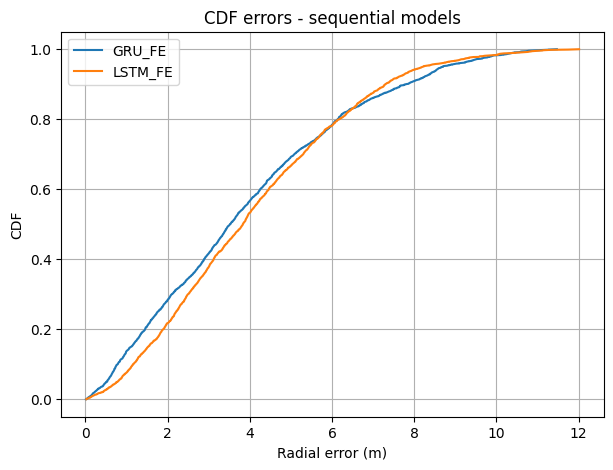

In [12]:
seq_bundle = evaluation.prepare_seq_data(df_train, df_test, cfg=cfg, run_id=run_id, force_recompute=force_recompute)
seq_out = evaluation.eval_seq_models(seq_bundle, cfg=cfg)
if len(seq_out) == 2:
    metrics_df_seq, preds_seq_pointwise = seq_out
    preds_seq = {}
else:
    metrics_df_seq, preds_seq_pointwise, preds_seq = seq_out
artifacts.save_df(metrics_df_seq, artifacts.artifact_path("metrics", "results_seq", run_id, "csv"))
metrics_df_seq

plotting.plot_error_cdf(
    metrics_df_seq,
    title="CDF errors - sequential models",
    max_m=None,
    save_path=paths.out_figures_dir() / f"cdf_seq__{run_id}.png",
)


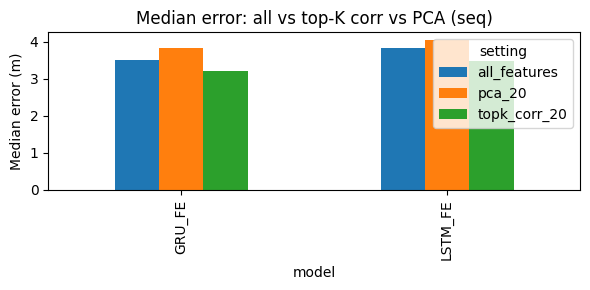

In [13]:
# Compare sequential models: all features vs top-K corr vs PCA
cfg.seq_use_pca = False
cfg.seq_use_topk_corr = False
seq_bundle_np = evaluation.prepare_seq_data(df_train, df_test, cfg=cfg, run_id=f"{run_id}_nopca", force_recompute=force_recompute)
seq_out_np = evaluation.eval_seq_models(seq_bundle_np, cfg=cfg)
if len(seq_out_np) == 2:
    metrics_np, _, = seq_out_np
else:
    metrics_np, _, _ = seq_out_np

cfg.seq_use_topk_corr = True
cfg.seq_use_pca = False
seq_bundle_topk = evaluation.prepare_seq_data(df_train, df_test, cfg=cfg, run_id=f"{run_id}_topk{K}", force_recompute=force_recompute)
seq_out_topk = evaluation.eval_seq_models(seq_bundle_topk, cfg=cfg)
if len(seq_out_topk) == 2:
    metrics_topk, _, = seq_out_topk
    preds_seq_topk = {}
else:
    metrics_topk, _, preds_seq_topk = seq_out_topk

cfg.seq_use_pca = True
cfg.seq_use_topk_corr = False
seq_bundle_pca = evaluation.prepare_seq_data(df_train, df_test, cfg=cfg, run_id=f"{run_id}_pca{K}", force_recompute=force_recompute)
seq_out_pca = evaluation.eval_seq_models(seq_bundle_pca, cfg=cfg)
if len(seq_out_pca) == 2:
    metrics_pca, _, = seq_out_pca
else:
    metrics_pca, _, _ = seq_out_pca

metrics_np = metrics_np.copy()
metrics_np["setting"] = "all_features"
metrics_topk = metrics_topk.copy()
metrics_topk["setting"] = f"topk_corr_{K}"
metrics_pca = metrics_pca.copy()
metrics_pca["setting"] = f"pca_{K}"
comp = pd.concat([metrics_np, metrics_topk, metrics_pca], ignore_index=True)
comp[["model", "setting", "median_err_m", "p95_err_m"]]

pivot = comp.pivot_table(index="model", columns="setting", values="median_err_m")
pivot.plot(kind="bar", figsize=(6,3))
plt.title("Median error: all vs top-K corr vs PCA (seq)")
plt.ylabel("Median error (m)")
plt.tight_layout()
plt.savefig(paths.out_figures_dir() / f"seq_feature_compare__{run_id}.png", dpi=150, bbox_inches="tight")
plt.show()


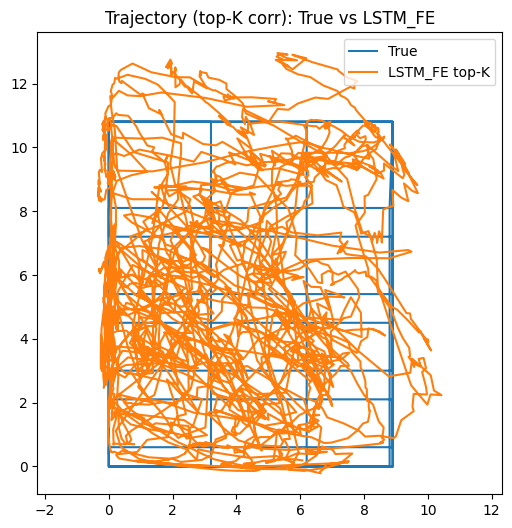

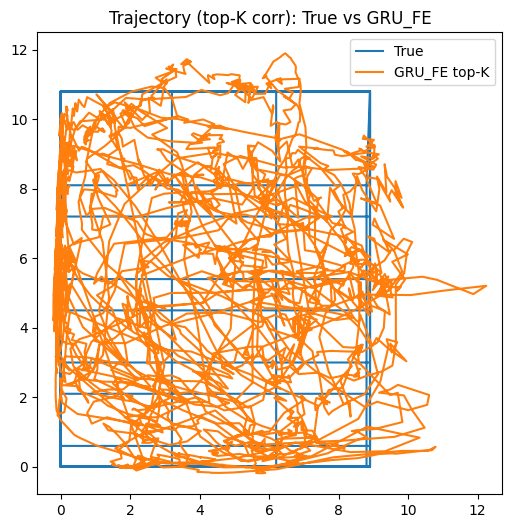

In [14]:
# Trajectories for top-K corr (sequential windows)
if 'preds_seq_topk' in globals() and preds_seq_topk:
    idx_seq_topk = np.asarray(seq_bundle_topk["idx_seq_test"], dtype=int)
    order = np.argsort(idx_seq_topk)
    for name in ["LSTM_FE", "GRU_FE"]:
        pack = preds_seq_topk.get(name)
        if pack is None:
            continue
        y_true_seq = pack["y_true"][order]
        y_pred_seq = pack["y_pred"][order]
        plt.figure(figsize=(6, 6))
        plt.plot(y_true_seq[:, 0], y_true_seq[:, 1], label="True")
        plt.plot(y_pred_seq[:, 0], y_pred_seq[:, 1], label=f"{name} top-K")
        plt.title(f"Trajectory (top-K corr): True vs {name}")
        plt.axis("equal")
        handles, labels = plt.gca().get_legend_handles_labels()
        if labels:
            plt.legend()
        plt.savefig(paths.out_figures_dir() / f"traj_seq_{name}_topk__{run_id}.png", dpi=150, bbox_inches="tight")
        plt.show()
else:
    print("Top-K corr sequential predictions not available.")


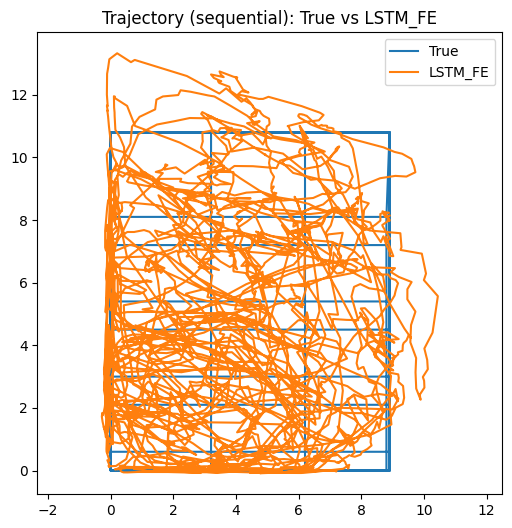

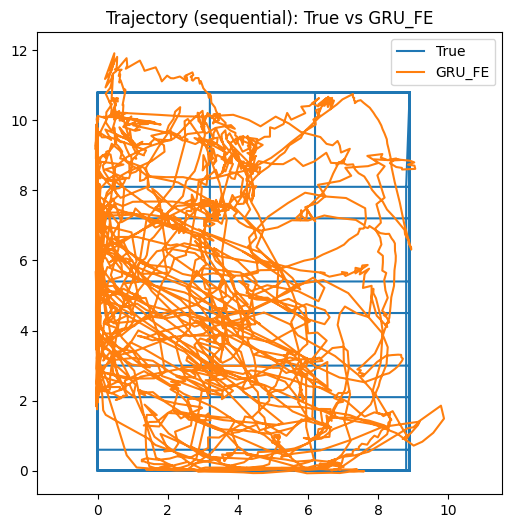

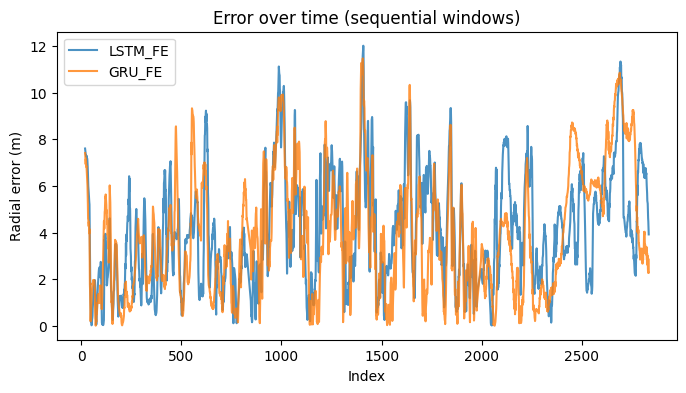

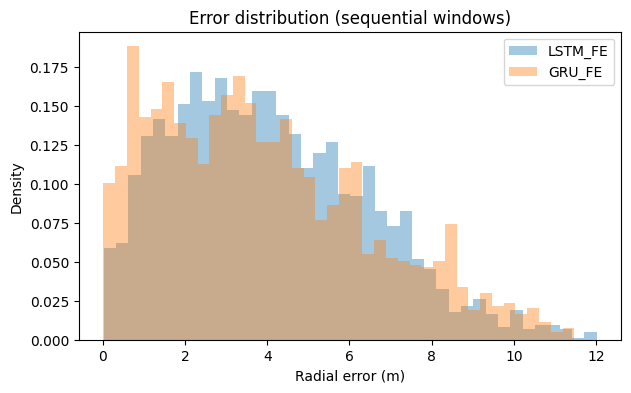

In [15]:
# Trajectory: true vs predicted (sequential, window outputs)
idx_seq = np.asarray(seq_bundle["idx_seq_test"], dtype=int)
order = np.argsort(idx_seq)
for name in ["LSTM_FE", "GRU_FE"]:
    pack = preds_seq.get(name)
    if pack is None:
        continue
    y_true_seq = pack["y_true"][order]
    y_pred_seq = pack["y_pred"][order]
    plt.figure(figsize=(6, 6))
    plt.plot(y_true_seq[:, 0], y_true_seq[:, 1], label="True")
    plt.plot(y_pred_seq[:, 0], y_pred_seq[:, 1], label=name)
    plt.title(f"Trajectory (sequential): True vs {name}")
    plt.axis("equal")
    handles, labels = plt.gca().get_legend_handles_labels()
    if labels:
        plt.legend()
    plt.savefig(paths.out_figures_dir() / f"traj_seq_{name}__{run_id}.png", dpi=150, bbox_inches="tight")
    plt.show()

# Error vs index (sequential windows)
plt.figure(figsize=(8, 4))
for name in ["LSTM_FE", "GRU_FE"]:
    pack = preds_seq.get(name)
    if pack is None:
        continue
    y_true_seq = pack["y_true"][order]
    y_pred_seq = pack["y_pred"][order]
    err = np.linalg.norm(y_pred_seq - y_true_seq, axis=1)
    plt.plot(idx_seq[order], err, label=name, alpha=0.8)
plt.title("Error over time (sequential windows)")
plt.xlabel("Index")
plt.ylabel("Radial error (m)")
handles, labels = plt.gca().get_legend_handles_labels()
if labels:
    handles, labels = plt.gca().get_legend_handles_labels()
    if labels:
        plt.legend()
plt.savefig(paths.out_figures_dir() / f"err_time_seq__{run_id}.png", dpi=150, bbox_inches="tight")
plt.show()

# Error histogram (sequential windows)
plt.figure(figsize=(7, 4))
for name in ["LSTM_FE", "GRU_FE"]:
    pack = preds_seq.get(name)
    if pack is None:
        continue
    y_true_seq = pack["y_true"]
    y_pred_seq = pack["y_pred"]
    err = np.linalg.norm(y_pred_seq - y_true_seq, axis=1)
    plt.hist(err, bins=40, alpha=0.4, label=name, density=True)
plt.title("Error distribution (sequential windows)")
plt.xlabel("Radial error (m)")
plt.ylabel("Density")
handles, labels = plt.gca().get_legend_handles_labels()
if labels:
    plt.legend()
plt.savefig(paths.out_figures_dir() / f"hist_seq__{run_id}.png", dpi=150, bbox_inches="tight")
plt.show()


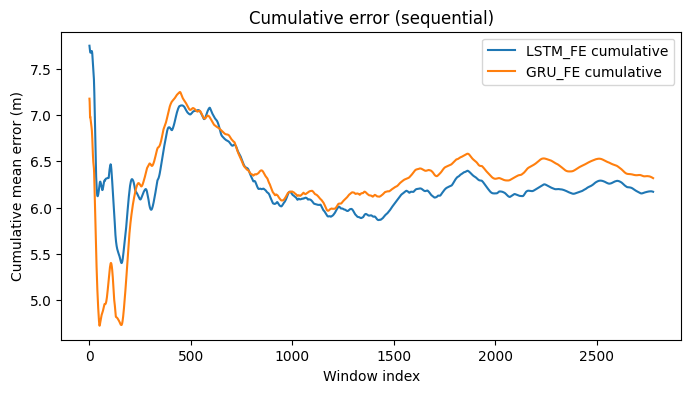

In [16]:
# Drift analysis: cumulative error over time (sequential)
y_true = df_test[["label_X", "label_Y"]].to_numpy()
plt.figure(figsize=(8, 4))
for name in ["LSTM_FE", "GRU_FE"]:
    y_pred = preds_seq_pointwise.get(name)
    if y_pred is None:
        continue
    mask = np.isfinite(y_pred).all(axis=1)
    err = np.linalg.norm(y_pred[mask] - y_true[mask], axis=1)
    cum = np.cumsum(err) / (np.arange(len(err)) + 1)
    plt.plot(cum, label=f"{name} cumulative")
plt.title("Cumulative error (sequential)")
plt.xlabel("Window index")
plt.ylabel("Cumulative mean error (m)")
handles, labels = plt.gca().get_legend_handles_labels()
if labels:
    plt.legend()
plt.savefig(paths.out_figures_dir() / f"cum_err_seq__{run_id}.png", dpi=150, bbox_inches="tight")
plt.show()


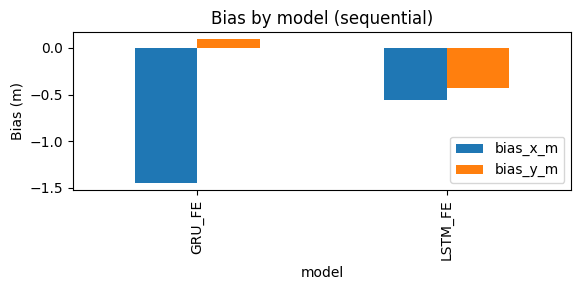

In [17]:
# Bias (X/Y) for sequential models
bias = metrics_df_seq[["model", "bias_x_m", "bias_y_m"]].copy()
bias.set_index("model")[["bias_x_m", "bias_y_m"]].plot(kind="bar", figsize=(6, 3))
plt.title("Bias by model (sequential)")
plt.ylabel("Bias (m)")
plt.tight_layout()
plt.savefig(paths.out_figures_dir() / f"bias_seq__{run_id}.png", dpi=150, bbox_inches="tight")
plt.show()


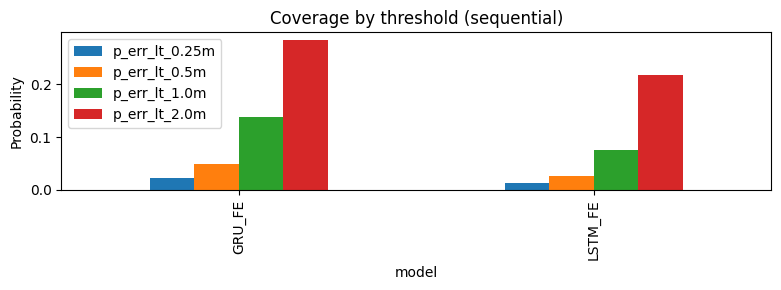

In [18]:
# Coverage (P(error < threshold)) for sequential models
cov_cols = [c for c in metrics_df_seq.columns if c.startswith("p_err_lt_")]
metrics_df_seq.set_index("model")[cov_cols].plot(kind="bar", figsize=(8, 3))
plt.title("Coverage by threshold (sequential)")
plt.ylabel("Probability")
plt.tight_layout()
plt.savefig(paths.out_figures_dir() / f"coverage_seq__{run_id}.png", dpi=150, bbox_inches="tight")
plt.show()


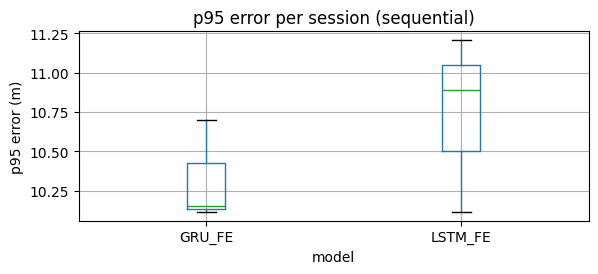

In [19]:
# Per-session metrics for sequential models
rows = []
y_true = df_test[["label_X", "label_Y"]].to_numpy()
if "session_id" not in df_test.columns:
    df_test = splitting.add_session_id(df_test)
for name, y_pred in preds_seq_pointwise.items():
    if y_pred is None:
        continue
    mask = np.isfinite(y_pred).all(axis=1)
    for sid, idx in df_test.loc[mask].groupby("session_id").groups.items():
        idx = np.asarray(list(idx), dtype=int)
        res = metrics.evaluate_regression(y_true[idx], y_pred[idx], name, thresholds=cfg.thresholds)
        res.update({"session_id": sid})
        rows.append(res)
seq_session_df = pd.DataFrame(rows)
if not seq_session_df.empty:
    seq_session_df.boxplot(column="p95_err_m", by="model", figsize=(6, 3))
    plt.title("p95 error per session (sequential)")
    plt.suptitle("")
    plt.ylabel("p95 error (m)")
    plt.tight_layout()
    plt.savefig(paths.out_figures_dir() / f"box_p95_sessions_seq__{run_id}.png", dpi=150, bbox_inches="tight")
    plt.show()


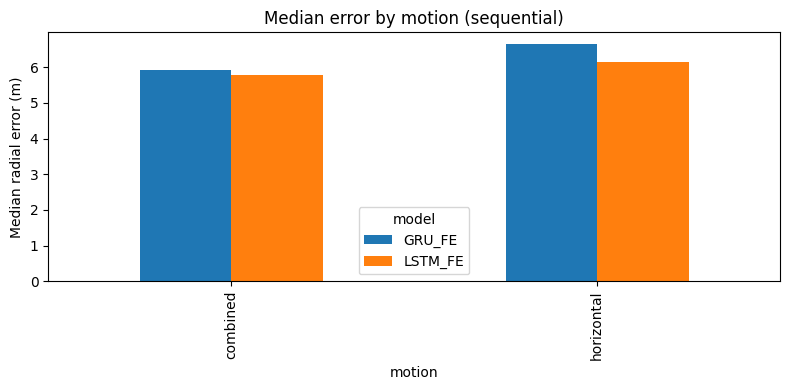

In [20]:
# Error by motion for sequential models
rows = []
y_true = df_test[["label_X", "label_Y"]].to_numpy()
for name, y_pred in preds_seq_pointwise.items():
    if y_pred is None:
        continue
    mask = np.isfinite(y_pred).all(axis=1)
    tmp = df_test[["motion"]].copy()
    tmp = tmp.loc[mask].reset_index(drop=True)
    tmp["err"] = np.linalg.norm(y_pred[mask] - y_true[mask], axis=1)
    g = tmp.groupby("motion").err.median().reset_index()
    g["model"] = name
    rows.append(g)
if rows:
    dm = pd.concat(rows, ignore_index=True)
    pivot = dm.pivot_table(index=["motion"], columns="model", values="err")
    pivot.plot(kind="bar", figsize=(8, 4))
    plt.title("Median error by motion (sequential)")
    plt.ylabel("Median radial error (m)")
    plt.tight_layout()
    plt.savefig(paths.out_figures_dir() / f"err_motion_seq__{run_id}.png", dpi=150, bbox_inches="tight")
    plt.show()


### LSTM

In [21]:
metrics_df_seq[metrics_df_seq["model"] == "LSTM_FE"]


,model,n,rmse_2d_m,mae_2d_m,median_err_m,p68_err_m,p90_err_m,p95_err_m,p99_err_m,max_err_m,...,rmse_y_m,mae_x_m,mae_y_m,bias_x_m,bias_y_m,errors_radial_m,p_err_lt_0.25m,p_err_lt_0.5m,p_err_lt_1.0m,p_err_lt_2.0m
1,LSTM_FE,2779,4.716802,4.079113,3.831114,5.115856,7.298764,8.212697,10.471829,12.013439,...,3.481646,2.374272,2.68854,-0.559747,-0.435162,"[7.607849757763863, 7.518161838120125, 7.44702...",0.012954,0.026628,0.076286,0.217344


### GRU

In [22]:
metrics_df_seq[metrics_df_seq["model"] == "GRU_FE"]


,model,n,rmse_2d_m,mae_2d_m,median_err_m,p68_err_m,p90_err_m,p95_err_m,p99_err_m,max_err_m,...,rmse_y_m,mae_x_m,mae_y_m,bias_x_m,bias_y_m,errors_radial_m,p_err_lt_0.25m,p_err_lt_0.5m,p_err_lt_1.0m,p_err_lt_2.0m
0,GRU_FE,2779,4.692572,3.917152,3.517356,4.893729,7.806851,8.699948,10.411103,11.471819,...,3.216403,2.439309,2.365186,-1.444627,0.088761,"[7.412670737104357, 7.331388893071025, 7.09078...",0.02231,0.048219,0.1371,0.283555


## Étape 6 —Analyse cross-device

Procédure appliquée :
- Séparation des données par appareil (ESP32 / smartphone Samsung).
- Entraînement des modèles tabulaires (Random Forest, XGBoost) sur un appareil source.
- Évaluation sur l’appareil cible, sans données communes entre train et test.
- Feature engineering réalisé séparément afin d’éviter toute fuite de données, avec alignement des colonnes entre domaines.
- Exclusion du champ `device` des features d’entrée afin de simuler une situation réaliste où l’appareil cible est inconnu à l’entraînement.
- Calcul des métriques globales (median, p90, p95) via `evaluate_regression`.
- Visualisation des performances par :
  - CDF de l’erreur euclidienne,
  - évolution de l’erreur au cours du temps,
  - comparaison spatiale des positions réelles et prédites.

Critères d’interprétation :
- Une bonne robustesse cross-device se traduit par une dégradation modérée des métriques (médiane et p95) par rapport au cas intra-device.
- Une forte augmentation de p95/p99 indique un **domain shift** important entre appareils (différences de calibration capteurs et WiFi).
- La symétrie ou non des résultats (ESP32 → Samsung vs Samsung → ESP32) permet d’identifier un appareil plus stable ou mieux instrumenté.
- Les visualisations (CDF et nuages de points) sont utilisées pour distinguer :
  - une erreur globale diffuse (bruit),
  - des erreurs structurées liées à certaines zones ou types de mouvement.
- Les performances cross-device sont analysées comme une **limite structurelle du système**, et non comme un problème d’optimisation des modèles.


c:\Users\flavi\GitHub\Indoor Localization\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:2999: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\flavi\GitHub\Indoor Localization\.venv\Lib\site-packages\numpy\lib\_function_base_impl.py:3000: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
c:\Users\flavi\GitHub\Indoor Localization\src\evaluation.py:435: RuntimeWarning: Mean of empty slice
  score = np.nanmean([abs(corr_x), abs(corr_y)])


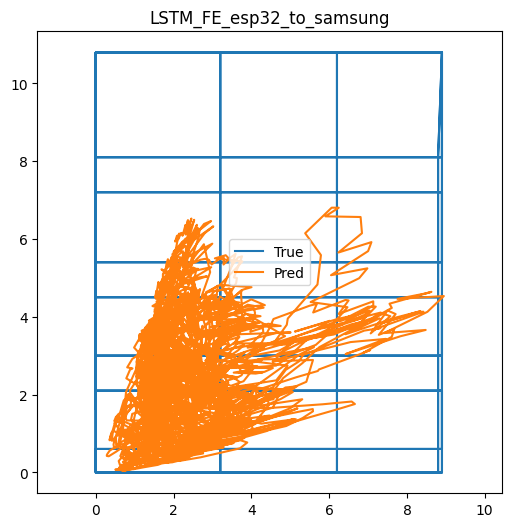

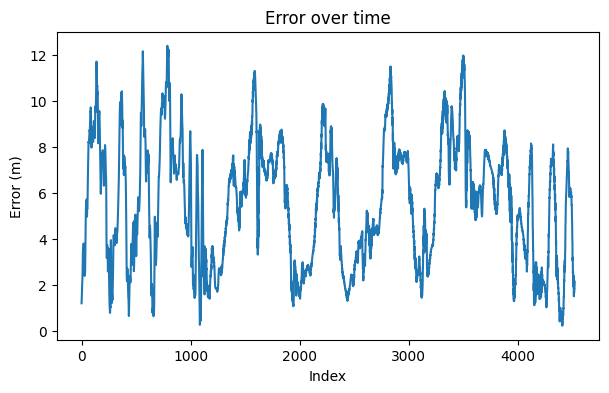

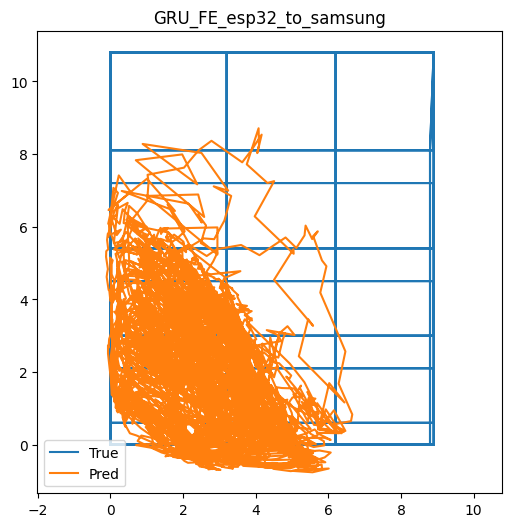

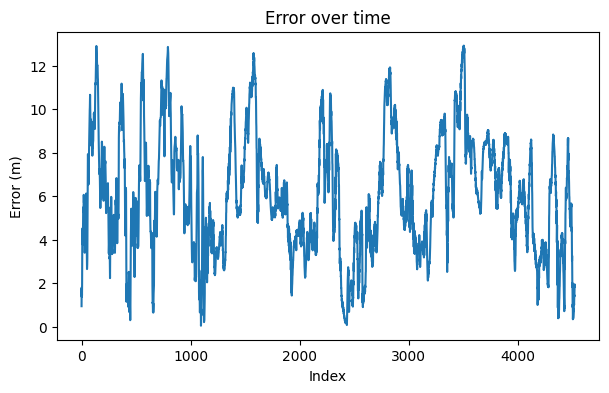

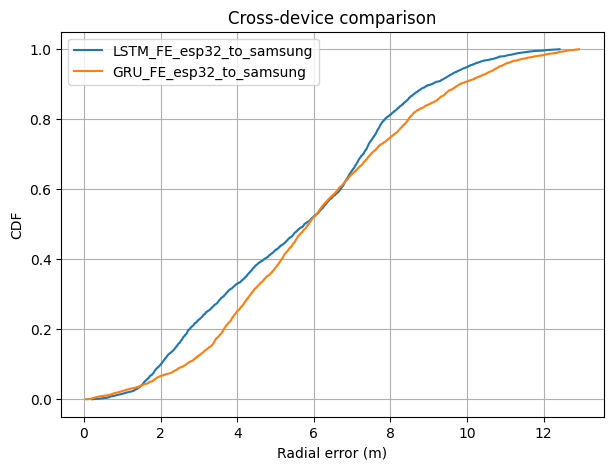

In [23]:
# Cross-device evaluation with sequential models (LSTM/GRU)
devices = df_base["device"].dropna().unique()
cross_results = []
if len(devices) >= 2:
    devA, devB = devices[0], devices[1]
    dfA = df_base[df_base["device"] == devA].reset_index(drop=True)
    dfB = df_base[df_base["device"] == devB].reset_index(drop=True)
    seq_bundle_cd = evaluation.prepare_seq_data(
        dfA, dfB, cfg=cfg, run_id=f"{run_id}_cd_{devA}_to_{devB}", force_recompute=force_recompute
    )
    metrics_cd, _, preds_seq_cd = evaluation.eval_seq_models(seq_bundle_cd, cfg=cfg)
    for name in ["LSTM_FE", "GRU_FE"]:
        pack = preds_seq_cd.get(name)
        if pack is None:
            continue
        res = {
            "name": f"{name}_{devA}_to_{devB}",
            "y_true": pack["y_true"],
            "y_pred": pack["y_pred"],
        }
        cross_results.append(res)
        plotting.plot_cross_device_result(res, save_dir=paths.out_figures_dir())
    if cross_results:
        plotting.plot_cross_device_comparison(cross_results, save_path=paths.out_figures_dir() / f"cdf_cross_seq__{run_id}.png")
else:
    print("Not enough devices for cross-device eval.")


Cette expérience montre une mauvais généralisation de samsung vers esp32 mais une généralisation plutôt correcte de esp32 vers samsung

## Étape 7 — Analyse par trajectoire

Procédure appliquée :
- Agrégation des prédictions par modèle alignées sur le dataframe test.
- Calcul des métriques par session (median, p90, p95, p99) via evaluate_regression.
- Identification des pires sessions pour inspection (boxplots p95, CDF par session).

Critères d'interprétation :
- Une bonne baseline est robuste inter‑session (faible médiane et p95 stable).
- Les séquentiels sont valorisés si ils réduisent significativement p95/p99 sur sessions difficiles.
- Repérer sessions problématiques (device/motion) pour prioriser correction labels ou calibration device‑wise.

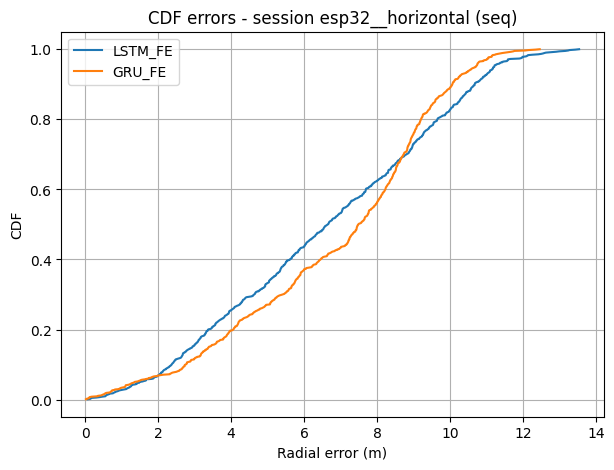

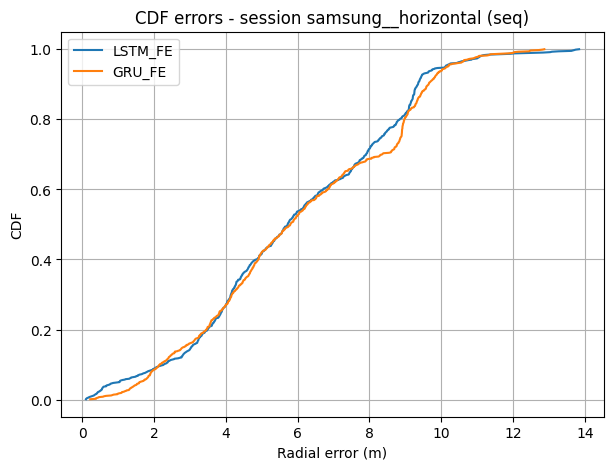

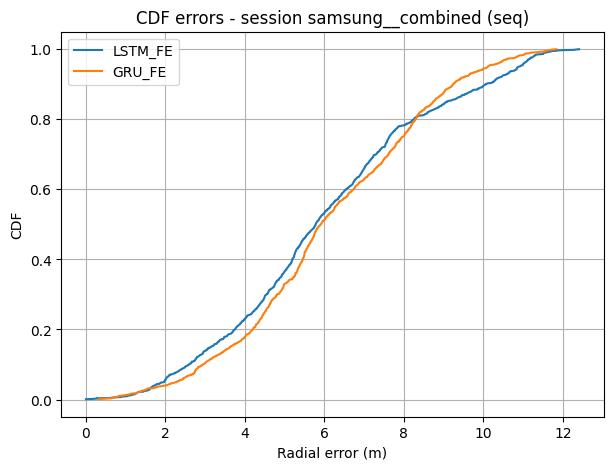

In [24]:
# Session analysis for sequential models only
rows = []
y_true = df_test[["label_X", "label_Y"]].to_numpy()
if "session_id" not in df_test.columns:
    df_test = splitting.add_session_id(df_test)
for name, y_pred in preds_seq_pointwise.items():
    if y_pred is None:
        continue
    mask = np.isfinite(y_pred).all(axis=1)
    df_mask = df_test.loc[mask].reset_index(drop=True)
    y_true_m = y_true[mask]
    y_pred_m = y_pred[mask]
    for sid, idx in df_mask.groupby("session_id").groups.items():
        idx = np.asarray(list(idx), dtype=int)
        res = metrics.evaluate_regression(y_true_m[idx], y_pred_m[idx], name, thresholds=cfg.thresholds)
        res.update({"session_id": sid, "device": df_mask.loc[idx[0], "device"], "motion": df_mask.loc[idx[0], "motion"]})
        rows.append(res)
session_df = pd.DataFrame(rows)
artifacts.save_df(session_df, artifacts.artifact_path("metrics", "session_long_seq", run_id, "csv"))

# p95 pivot for sequential models
p95_pivot = (
    session_df.pivot_table(index=["session_id", "device", "motion"], columns="model", values="p95_err_m", aggfunc="first")
    .reset_index()
)
artifacts.save_df(p95_pivot, artifacts.artifact_path("metrics", "p95_pivot_seq", run_id, "csv"))
p95_pivot.head()

# Plot CDFs for worst sessions (sequential best model)
best_model = session_df.groupby("model")["p95_err_m"].median().sort_values().index[0]
worst_sessions = (
    session_df[session_df["model"] == best_model]
    .sort_values("p95_err_m", ascending=False)
    .head(3)["session_id"]
    .tolist()
)
for sid in worst_sessions:
    df_s = session_df[session_df["session_id"] == sid]
    plotting.plot_error_cdf(
        df_s,
        title=f"CDF errors - session {sid} (seq)",
        max_m=None,
        save_path=paths.out_figures_dir() / f"cdf_session_seq_{sid}__{run_id}.png",
    )


C:\Users\flavi\AppData\Local\Temp\ipykernel_23968\3386344455.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, positions=[list(session_df["model"].unique()).index(m)], labels=[m], showfliers=True)
C:\Users\flavi\AppData\Local\Temp\ipykernel_23968\3386344455.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(vals, positions=[list(session_df["model"].unique()).index(m)], labels=[m], showfliers=True)


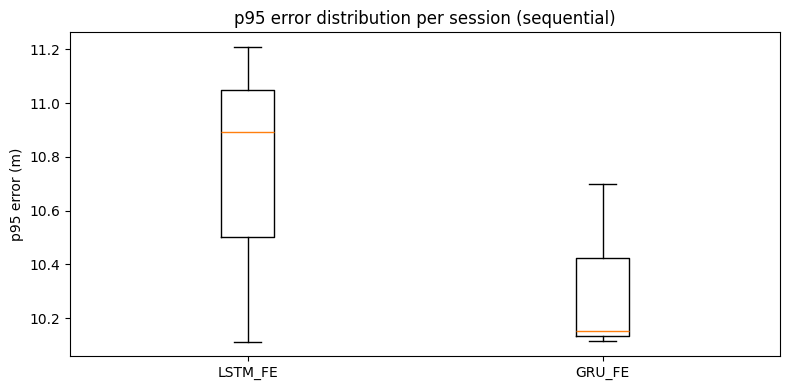

In [25]:
# Boxplot of p95 errors per session (sequential)
plt.figure(figsize=(8, 4))
for m in session_df["model"].unique():
    vals = session_df.loc[session_df["model"] == m, "p95_err_m"].dropna().to_numpy()
    plt.boxplot(vals, positions=[list(session_df["model"].unique()).index(m)], labels=[m], showfliers=True)
plt.title("p95 error distribution per session (sequential)")
plt.ylabel("p95 error (m)")
plt.tight_layout()
plt.savefig(paths.out_figures_dir() / f"box_p95_sessions_seq__{run_id}.png", dpi=150, bbox_inches="tight")
plt.show()


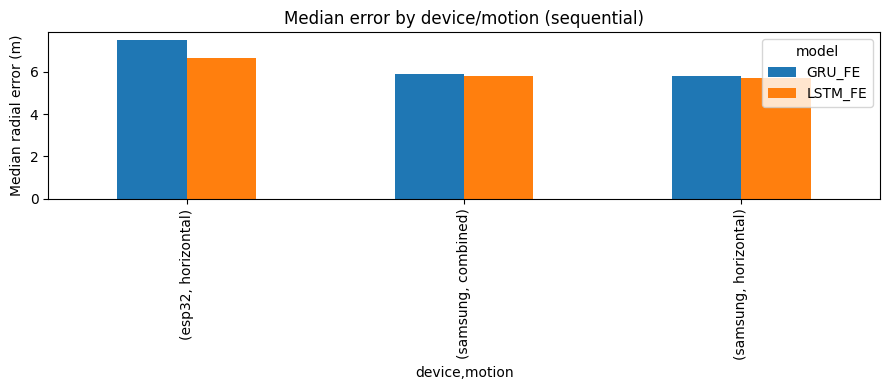

In [26]:
# Error by device/motion (median) for sequential models
rows = []
y_true = df_test[["label_X", "label_Y"]].to_numpy()
for name, y_pred in preds_seq_pointwise.items():
    if y_pred is None:
        continue
    mask = np.isfinite(y_pred).all(axis=1)
    tmp = df_test.loc[mask, ["device", "motion"]].copy()
    tmp["err"] = np.linalg.norm(y_pred[mask] - y_true[mask], axis=1)
    g = tmp.groupby(["device", "motion"]).err.median().reset_index()
    g["model"] = name
    rows.append(g)
if rows:
    dm = pd.concat(rows, ignore_index=True)
    pivot = dm.pivot_table(index=["device", "motion"], columns="model", values="err")
    pivot.plot(kind="bar", figsize=(9, 4))
    plt.title("Median error by device/motion (sequential)")
    plt.ylabel("Median radial error (m)")
    plt.tight_layout()
    plt.savefig(paths.out_figures_dir() / f"err_device_motion_seq__{run_id}.png", dpi=150, bbox_inches="tight")
    plt.show()


### Commentaire sur la CDF des erreurs et limites du RMSE

- Les CDF tabulaires et s?quentielles ne sont pas directement comparables si elles ne portent pas sur le m?me ensemble de points.
- Les mod?les s?quentiels sont ?valu?s sur des sorties de fen?tres (n?4524) alors que les tabulaires sont ?valu?s point?par?point (n?2836).
- Pour une comparaison honn?te, utiliser la CDF **common?mask** (m?mes indices) et expliciter la population ?valu?e.
- Le RMSE 2D est sensible aux outliers ; le p95 et les courbes de couverture (p(err<?)) sont plus robustes pour juger la stabilit? indoor.


## Étape 8 — Analyse des résultats et discussion

Une solution hybride pourrait combiner les forces des modèles séquentiels (LSTM, GRU) et des modèles non séquentiels (XGBoost, RF). L'idée est d'utiliser les prédictions des modèles non séquentiels comme entrées supplémentaires pour les modèles séquentiels, améliorant ainsi la capture des dépendances temporelles tout en bénéficiant d'une modélisation robuste des relations non linéaires.

Ici nous faisons une hybridation naïve pour voir le potentiel de cette méthode.

### Hybridation XGBoost × LSTM — approche naïve

Cette approche combine un modèle pointwise (XGBoost) et un modèle séquentiel (LSTM) afin d’exploiter leurs propriétés complémentaires.

XGBoost fournit une estimation de position généralement plus stable en valeur absolue, mais bruitée dans le temps.  
Le LSTM exploite l’historique temporel pour produire des prédictions plus lisses, au prix d’une dérive spatiale possible.

L’hybridation retenue consiste en une combinaison linéaire simple des deux prédictions :

y_out = α · y_XGB + (1 − α) · y_LSTM

avec un coefficient α fixé à 0.5, correspondant à une pondération uniforme (50 % XGBoost, 50 % LSTM).

Cette méthode constitue une baseline d’hybridation simple, utilisée pour évaluer si la combinaison directe permet de réduire le bruit des prédictions pointwise tout en limitant la dérive des modèles séquentiels, sans introduire de complexité supplémentaire.

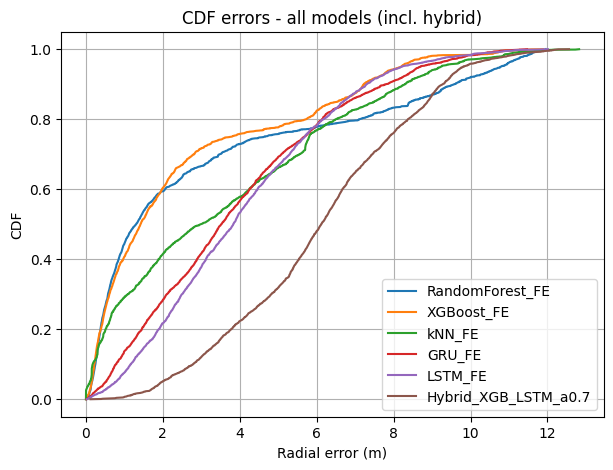

In [27]:
alpha = 0.7
y_true = df_test[["label_X", "label_Y"]].to_numpy()
xgb_pred = preds_by_model.get("XGBoost_FE")
lstm_pred = preds_seq_pointwise.get("LSTM_FE")
if xgb_pred is not None and lstm_pred is not None:
    mask = np.isfinite(lstm_pred).all(axis=1)
    y_true_h = y_true[mask]
    xgb_h = xgb_pred[mask]
    lstm_h = lstm_pred[mask]
    y_hybrid = alpha * xgb_h + (1 - alpha) * lstm_h
    res_hybrid = metrics.evaluate_regression(y_true_h, y_hybrid, f"Hybrid_XGB_LSTM_a{alpha}", thresholds=cfg.thresholds)
    results_all = pd.DataFrame(list(results_df.to_dict("records")) + list(metrics_df_seq.to_dict("records")) + [res_hybrid])
    plotting.plot_error_cdf(
        results_all,
        title="CDF errors - all models (incl. hybrid)",
        max_m=None,
        save_path=paths.out_figures_dir() / f"cdf_all__{run_id}.png",
    )
    results_all.sort_values("median_err_m").reset_index(drop=True)
else:
    print("Missing XGB or LSTM predictions for hybridation.")


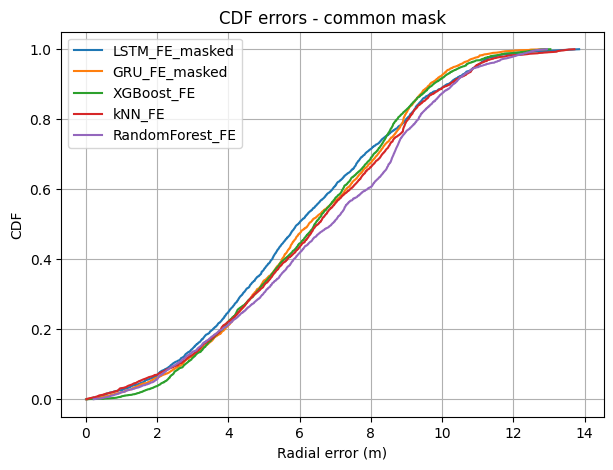

In [28]:
# Common-mask evaluation (tabular + seq + hybrid) on same points
y_true = df_test[["label_X", "label_Y"]].to_numpy()
mask = None
if "LSTM_FE" in preds_seq_pointwise:
    mask = np.isfinite(preds_seq_pointwise["LSTM_FE"]).all(axis=1)
elif "GRU_FE" in preds_seq_pointwise:
    mask = np.isfinite(preds_seq_pointwise["GRU_FE"]).all(axis=1)
if mask is None:
    print("No sequential predictions available for common-mask eval")
else:
    rows = []
    for name, y_pred in preds_by_model.items():
        rows.append(metrics.evaluate_regression(y_true[mask], y_pred[mask], name, thresholds=cfg.thresholds))
    for name, y_pred in preds_seq_pointwise.items():
        if y_pred is None:
            continue
        rows.append(metrics.evaluate_regression(y_true[mask], y_pred[mask], name + "_masked", thresholds=cfg.thresholds))
    common_df = pd.DataFrame(rows).sort_values("median_err_m").reset_index(drop=True)
    common_df
    plotting.plot_error_cdf(
        common_df,
        title="CDF errors - common mask",
        max_m=None,
        save_path=paths.out_figures_dir() / f"cdf_common_mask__{run_id}.png",
    )


Les résultats de l’approche hybride montrent une meilleure concentration des prédictions dans la zone correspondant à la salle, par rapport aux modèles utilisés individuellement. Toutefois, la précision obtenue reste insuffisante pour atteindre les performances attendues en localisation absolue.

La forme naïve de l’hybridation n’apporte pas d’amélioration significative des métriques globales, mais elle met en évidence un potentiel de complémentarité entre les approches pointwise et séquentielles. Ces observations suggèrent qu’une stratégie d’hybridation plus élaborée, notamment avec une pondération adaptative ou dépendante du contexte, pourrait permettre d’exploiter plus efficacement les atouts de chaque modèle.

Par exemple utiliser les prédictions pointwise en entrées du modèle séquentiel puis générer un delta de correction pour lisser le résultat permettrait de mieux tirer partie des avantages de chaque modèle.

## 9. Conclusion - comparaison des modèles

Résumé des objectifs  
- Estimer la position 2D à partir d'IMU et de RSSI, comparer approches pointwise (kNN, RF, XGBoost) et séquentielles (LSTM, GRU), et évaluer la robustesse par session (device/motion).

Principaux résultats
- Modèle linéaire : insuffisant pour capturer la non‑linéarité présente dans les données brutes.
- kNN (fingerprinting) : performant pour des erreurs faibles en zones denses d'empreintes, mais peu robuste aux variations de RSSI et aux sessions non‑observées.
- Modèles tabulaires : Random Forest fournit la meilleure robustesse inter‑session sur nos jeux de données (médiane et p95 globalement faibles). XGBoost atteint une précision médiane comparable mais tend à produire des queues d'erreur plus longues (cas difficiles / outliers).
- Modèles séquentiels : LSTM et GRU n'améliorent pas systématiquement la médiane, mais apportent une réduction notable des erreurs extrêmes (p95/p99) sur certaines trajectoires complexes. Le GRU, plus simple, montre une meilleure stabilité quand le nombre de sessions est limité.
- Fusion hybride (ex. pondération XGBoost + LSTM sur une trajectoire test) : montre un effet bénéfique sur la trajectoire testée (lissage et réduction ponctuelle du RMSE) — résultat prometteur mais encore expérimental.

Recommandations pratiques
- Pour une baseline opérationnelle : déployer Random Forest / XGBoost (avec Group‑CV) et monitorer erreurs par session/device.  
- Pour la stabilité temporelle : privilégier une architecture GRU simple (ou un lissage post‑processing comme Kalman) et valider par sessions distinctes.  
- Pour les cas critiques : tester une stratégie hybride (pointwise pour information instantanée + séquentiel pour lissage) et évaluer systématiquement par Group‑CV.
- Vérifier systématiquement la qualité des labels densifiés (comparaison anchor vs densified) avant tout entraînement final.


In [29]:
best_tab = results_df.iloc[0].to_dict() if "results_df" in globals() else None
best_seq = metrics_df_seq.iloc[0].to_dict() if "metrics_df_seq" in globals() else None
if best_tab and "errors_radial_m" in best_tab:
    best_tab["errors_radial_m"] = None
if best_seq and "errors_radial_m" in best_seq:
    best_seq["errors_radial_m"] = None
summary = {
    "run_id": run_id,
    "best_tabular": best_tab,
    "best_seq": best_seq,
    "config": cfg.__dict__,
}
artifacts.save_json(summary, artifacts.artifact_path("metrics", "summary", run_id, "json"))


## 10. Conclusion générale

Apports du travail  
- Proposition d'un pipeline reproductible couvrant pretraitement, densification des labels, feature engineering (rolling, dérivées, sélection top‑K Wi‑Fi), et évaluation multi‑critères (médiane, p90/p95, CDF, analyse par session).  
- Comparaison méthodique entre modèles pointwise et séquentiels, et démonstration d'une approche hybride potentiellement bénéfique.

Limitations principales
- Densification linéaire des labels : simple et utile pour densifier les cibles, mais susceptible d'introduire du bruit sur trajectoires non linéaires.  
- Variabilité RSSI et hétérogénéité device : nécessite calibration ou normalisation device‑wise.  
- Taille / diversité des sessions limitée : impacte la généralisation des modèles séquentiels.

Priorités et voies d'amélioration
1. Validation qualité labels : comparer anchors vs densified sur échantillons critiques et corriger les segments biaisés.  
2. Validation robuste : lancer Group‑CV (sessions) pour RF/XGBoost et pour l'évaluation des combinaisons hybrides.  
3. Calibration device‑wise RSSI et normalisation des features de capteurs.  
4. Expérimenter des méthodes de fusion temporelle (Kalman / PDR / map‑matching) et pipelines hybrides (XGBoost → GRU).  
5. Collecte supplémentaire et définition fine de sessions (identifiants de trajectoire) pour augmenter la diversité et la validité des tests.

Conclusion opérationnelle  
- Le pipeline proposé constitue une base solide experimentale : Random Forest/XGBoost forment une baseline robuste, les modèles séquentiels (en particulier GRU) apportent un gain en stabilité temporelle sur des trajectoires complexes, et une stratégie hybride + corrections de labels et calibration device‑wise doit être priorisée pour une démonstration applicative robuste.
